### Forecast Revisions with TimeDB

This notebook demonstrates overlapping forecast revisions:
1. Creating multiple forecasts for the same series with different `known_time`
2. Reading all revisions with `read(versions=True)`
3. Visualizing how forecasts evolve over time

In [1]:
from timedb import TimeDataClient
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

td = TimeDataClient()
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


In [2]:
forecast_series_id = td.create_series(
    name='forecast',
    unit='MW',
    labels={'type': 'power_forecast', 'model': 'sinus_with_error'},
    description='Forecasted power values with overlapping revisions',
    data_class='overlapping'
)

actual_series_id = td.create_series(
    name='flat',
    unit='MW',
    labels={'type': 'power_actual'},
    description='Actual power values (ground truth)'
)

for s in td.series().list_series():
    print(f"  {s['name']}: unit={s['unit']}  data_class={s['data_class']}  labels={s['labels']}")

  flat: unit=MW  data_class=flat  labels={'type': 'power_actual'}
  forecast: unit=MW  data_class=overlapping  labels={'model': 'sinus_with_error', 'type': 'power_forecast'}


## Part 2: Create 4 Forecasts with Shifting Valid Times

Each forecast has a 3-day (72h) horizon starting at its `known_time`, with forecasts issued 1 day apart. Forecast error grows with lead time — early hours are accurate, later hours diverge.

In [3]:
base_valid_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
forecast_horizon_hours = 72
num_forecasts = 4

# Generate "actual" power values over the full period (diurnal pattern + noise)
np.random.seed(0)
total_hours = (num_forecasts - 1) * 24 + forecast_horizon_hours
all_hours = np.arange(total_hours)
actuals = 80 + 40 * np.sin(2 * np.pi * all_hours / 24 - np.pi / 2) + np.random.normal(0, 3, total_hours)
actuals = np.clip(actuals, 0, None)  # power can't be negative

# Insert 4 forecasts — each starts at its known_time, error grows with lead time
for i in range(num_forecasts):
    known_time = base_valid_time + timedelta(days=i)
    start_idx = i * 24  # offset into actuals array
    valid_times = [known_time + timedelta(hours=j) for j in range(forecast_horizon_hours)]
    lead_hours = np.arange(forecast_horizon_hours)
    np.random.seed(42 + i)
    forecast_error = np.random.normal(0, 1 + 0.3 * lead_hours)
    forecast_values = np.round(actuals[start_idx:start_idx + forecast_horizon_hours] + forecast_error, 2)

    df_forecast = pd.DataFrame({"valid_time": valid_times, "forecast": forecast_values})
    td.series("forecast").where(type='power_forecast', model='sinus_with_error').insert(
        df=df_forecast, known_time=known_time
    )

# Insert actual values
actual_valid_times = [base_valid_time + timedelta(hours=i) for i in range(total_hours)]
df_actual = pd.DataFrame({"valid_time": actual_valid_times, "flat": np.round(actuals, 2)})
td.series("flat").where(type='power_actual').insert(df=df_actual)

print(f"Inserted {num_forecasts} forecast batches + actuals ({total_hours} hours)")

Inserted 4 forecast batches + actuals (144 hours)


## Part 3: Read Latest Forecast Revisions

Now we'll read back the latest forecast revisions using `td.read()`.
This returns the latest forecast for each valid_time (most recent based on known_time) in a single query.


In [4]:
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(hours=total_hours)

# Read latest forecast and actuals
df_forecast = td.series("forecast").where(
    type='power_forecast', model='sinus_with_error'
).read(start_valid=start_valid, end_valid=end_valid)

df_actual = td.series("flat").where(
    type='power_actual'
).read(start_valid=start_valid, end_valid=end_valid)

df_flat = pd.DataFrame({
    'forecast': df_forecast['forecast'],
    'actual': df_actual['flat']
}, index=df_forecast.index)

df_flat.head(10)

,forecast,actual
valid_time,,
2025-01-01 00:00:00+00:00,45.79,45.29
2025-01-01 01:00:00+00:00,42.38,42.56
2025-01-01 02:00:00+00:00,49.33,48.3
2025-01-01 03:00:00+00:00,61.33,58.44
2025-01-01 04:00:00+00:00,65.09,65.6
2025-01-01 05:00:00+00:00,66.13,66.72
2025-01-01 06:00:00+00:00,87.27,82.85
2025-01-01 07:00:00+00:00,92.28,89.9
2025-01-01 08:00:00+00:00,98.09,99.69


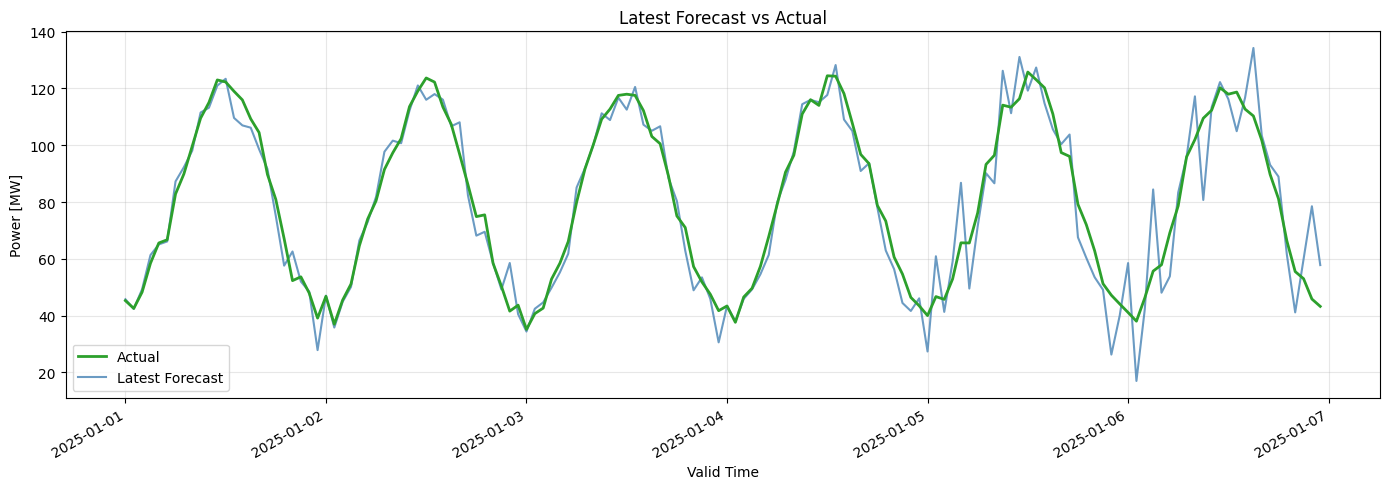

In [5]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df_flat.index, df_flat['actual'].astype(float), linewidth=2, color='#2ca02c', label='Actual', zorder=5)
ax.plot(df_flat.index, df_flat['forecast'].astype(float), linewidth=1.5, color='steelblue', label='Latest Forecast', alpha=0.8)

ax.set_xlabel('Valid Time')
ax.set_ylabel('Power [MW]')
ax.set_title('Latest Forecast vs Actual')
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Part 4: Read All Forecast Revisions (Overlapping Mode)

Now let's read all forecast revisions using `.read(versions=True)` on the series collection.
This returns all forecasts with both `known_time` and `valid_time`, showing how
forecasts evolve over time. This is useful for analyzing forecast revisions and backtesting.

In [6]:
# Read all forecast revisions with (known_time, valid_time) multi-index
df_forecast_overlapping = td.series("forecast").where(
    type='power_forecast', model='sinus_with_error'
).read(start_valid=start_valid, end_valid=end_valid, versions=True)

# Read actuals (flat)
df_actual_overlapping = td.series("flat").where(
    type='power_actual'
).read(start_valid=start_valid, end_valid=end_valid)

print(f"Forecast: {df_forecast_overlapping.shape}  index={df_forecast_overlapping.index.names}")
print(f"Actual:   {df_actual_overlapping.shape}  index={df_actual_overlapping.index.name}")
print()
df_forecast_overlapping.head(6)

Forecast: (288, 1)  index=['known_time', 'valid_time']
Actual:   (144, 1)  index=valid_time



name                                                 forecast
known_time                valid_time                         
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00     45.79
                          2025-01-01 01:00:00+00:00     42.38
                          2025-01-01 02:00:00+00:00     49.33
                          2025-01-01 03:00:00+00:00     61.33
                          2025-01-01 04:00:00+00:00     65.09
                          2025-01-01 05:00:00+00:00     66.13

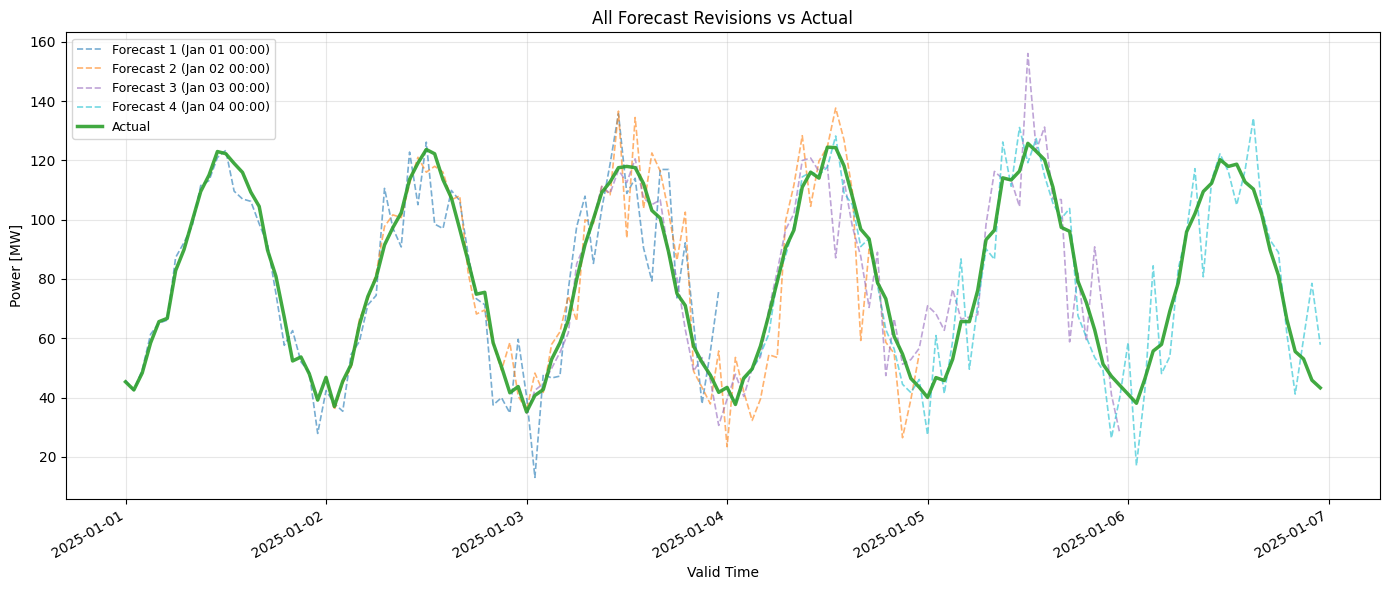

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each forecast revision in a distinct color
unique_known_times = sorted(df_forecast_overlapping.index.get_level_values("known_time").unique())
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#17becf']

for idx, known_time in enumerate(unique_known_times):
    forecast_data = df_forecast_overlapping.xs(known_time, level="known_time")
    values = forecast_data['forecast'].astype(float)
    label = f"Forecast {idx+1} ({known_time.strftime('%b %d %H:%M')})"
    ax.plot(forecast_data.index, values, linewidth=1.2, linestyle='--',
            color=colors[idx % len(colors)], alpha=0.6, label=label)

# Plot actuals on top
actual_vals = df_actual_overlapping['flat'].astype(float)
ax.plot(df_actual_overlapping.index, actual_vals, linewidth=2.5,
        color='#2ca02c', label='Actual', alpha=0.9, zorder=10)

ax.set_xlabel('Valid Time')
ax.set_ylabel('Power [MW]')
ax.set_title('All Forecast Revisions vs Actual')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Summary

- `known_time` = when the forecast was made; `valid_time` = what it predicts
- `data_class='overlapping'` enables versioned storage with `known_time` tracking
- `read()` returns the latest forecast (one value per `valid_time`)
- `read(versions=True)` returns all revisions with a `(known_time, valid_time)` multi-index